In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Overview

This star particle placement algorithm is ripped directly from TORCH's star formation method **`torch_sf.py`**. The method pulling mass from a sink particle and introducing it into the simulation space as a point star particle (AMUSE).

The algorithm detailed here has simplified inputs for ease of use and comprehension. Ultimately, stars are placed in a uniform distribution within the sink particle. At face value, this is certainly a logical way to proceed. Since a sink particle represents a volume of unstable collapsing gas within which star formation must be occuring **but** at a scale far to small to resolve. Therefore stars are then spawned uniformly at random positions within the sink particle region.

The issues with this method of star placement becomes more clear when we consider the restrictions placed on sink particles in FLASH and their dependencies with the level of max refinement. 

Consider a simulation in which a sink particle has already formed and has made some stars. Then you decide to restart the sim and increase the level of refinement by 1 level. This means that the stars-to-be-made inside the sink (as prescribed by the randomized star list) would then be placed within a region with 0.5x the radius, ~1/10th the volume. Of course this would alter the simulation, introducing stars in a much more confined form. 

Whether this effect produces clusters with unrealistic boundness I am unsure. It's true that there are other factors at play here, the stars' velocities are dependent on the velocity of the gas surrounding the sink particle, so a smaller sink may result in higher star velocities. 

When it comes to testing the effects of stellar feedback on the surrounding gas, a slightly more compact cluster should not have significant effects, since we really only care about getting the stars into the simulation. However, if the goal is to test the removal of gas and its effects on cluster dynamics, primordial binaries and their post-formation behavior, etc. it is assumed a varying compactness of the star forming region will have a more immediate effect.

Potential remedies for this include establishing a range in which stars are allowed to be placed that is constant in size no matter the size of the sink particle (and thereby the max refinement level). 

### Resolution:
Ultimately, the issue of stellar density placement is not substantial enough to warrant an in depth fix at this time. Especially since it seems there is no efforts in the literature to explain this (CHECK SORMANI+17)

## OTHER Considerations

In the current version of Torch (Jan. 15th 2019) stars are placed within a sink particle at a random position uniform in radial magnitude. This naturally creates a centrally concentrated structure within the sink with a distribution of $1/r^2$. This implies a false notion that we "know" the structure of the collapsing gas within the sink. For this reason, it may be more accurate/honest to have the stars spawn into the simulation at random points within the sink particle with a distribution uniform in density. 

In [62]:
def random_three_vector(n=1):
    """Algorithm pulled directly from refactored TORCH 
    commit ae044f7. Generates a 3D vector of magnitude 1
    that is directed from origin to the surface of a unit
    sphere."""
    three_vector = np.zeros((n,3))
    
    phi = np.random.uniform(0,np.pi*2,n)
    costheta = np.random.uniform(-1,1,n)
    
    theta = np.arccos( costheta )
    three_vector[:,0] = np.sin( theta) * np.cos( phi )
    three_vector[:,1] = np.sin( theta) * np.sin( phi )
    three_vector[:,2] = np.cos( theta )
    return three_vector


In [63]:
sink_pos = (0,0,0)
sink_rad = 100.0
nnew = 1000

star_position = sink_pos + sink_rad * np.random.rand(nnew, 1)*random_three_vector(nnew)



### Place stars inside Sink

N star particles are then placed **inside** the sink. Their location is chosen by scaling the 3D vector generated by random_three_vector() by a random amount (0-1). This results in a particle distribution that is uniform in magnitude which ultimately translates to a $1/r^2$ distribution.

In [64]:
def generate_star_coordinates(sink_rad, nstars):
    """Places n star particles within the given sink radius
    in a distribution uniform in magnitude."""
    sink_pos = (0,0,0)
    star_position = sink_pos + sink_rad * np.random.rand(nstars, 1)*random_three_vector(nstars)
    xlist = []
    ylist = []
    zlist = []
    maglist = []
    for i,j in enumerate(star_position):
        xlist.append(star_position[i][0])
        ylist.append(star_position[i][1])
        zlist.append(star_position[i][2])
        mag = np.sqrt(star_position[i][0] ** 2 + star_position[i][1] ** 2 + star_position[i][2] ** 2)
        maglist.append(mag)
    return xlist, ylist, zlist, maglist

In [65]:
# My skeletonized version of the above algorithm.

xlist = []
ylist = []
zlist = []
maglist = []
for i,j in enumerate(star_position):
    xlist.append(star_position[i][0])
    ylist.append(star_position[i][1])
    zlist.append(star_position[i][2])
    mag = np.sqrt(star_position[i][0] ** 2 + star_position[i][1] ** 2 + star_position[i][2] ** 2)
    maglist.append(mag)
    

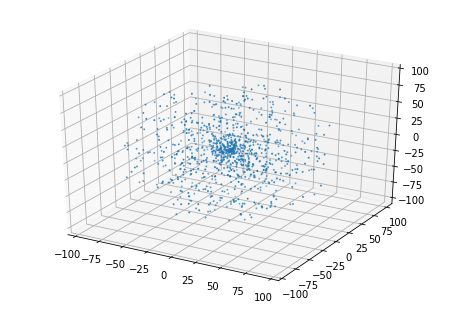

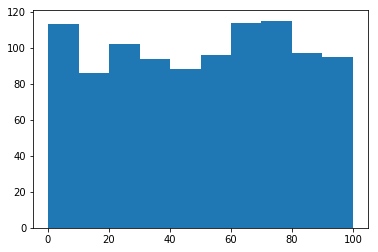

In [66]:
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(xlist, ylist, zlist, s=1)
plt.show()

plt.figure()
plt.hist(maglist)
plt.show()


## Above plots

Show a brief example distribution of 1000 stars as it would appear in the current version of Torch. 
In addition, it is shown that the magnitudes of the stars' distribution radii are uniform.

In [67]:
x, y, z, mag = generate_star_coordinates(100,1000)
xsmall, ysmall, zsmall, magsmall = generate_star_coordinates(50,1000)
xtiny, ytiny, ztiny, magtiny = generate_star_coordinates(25,1000)

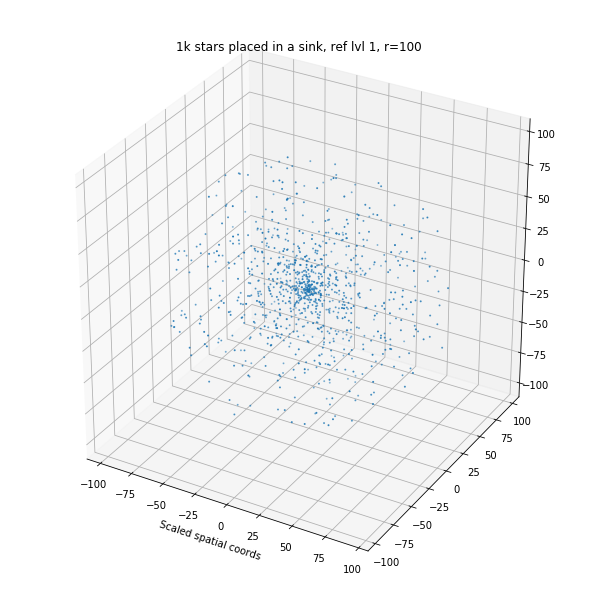

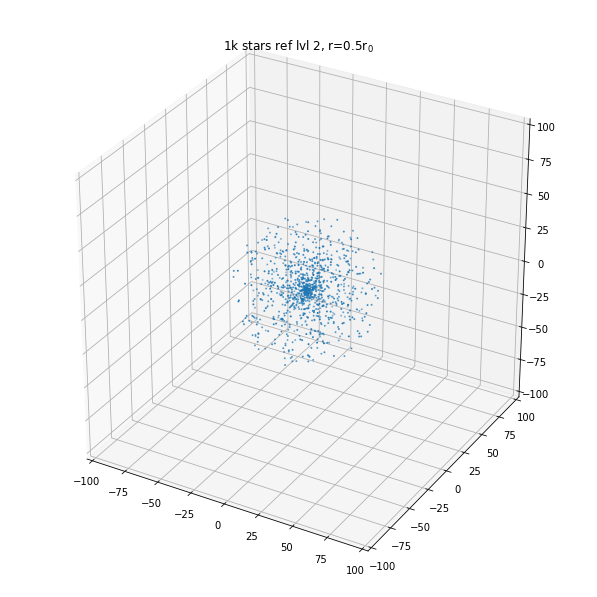

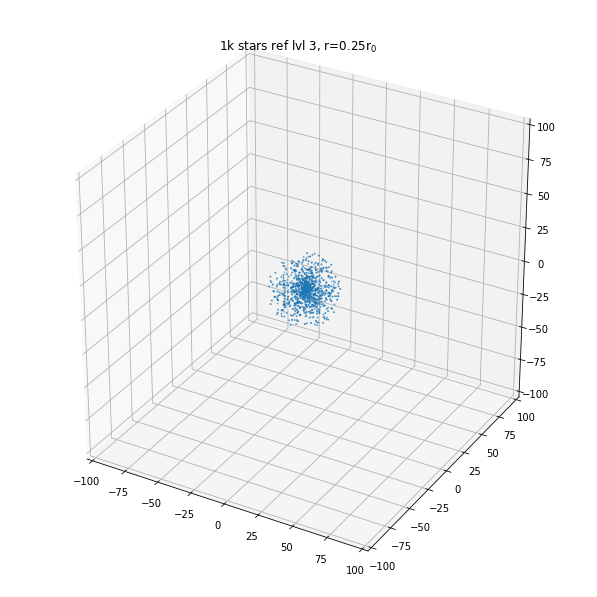

In [68]:
fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)
ax.scatter(x, y, z, s=1)
ax.set_title("1k stars placed in a sink, ref lvl 1, r=100")
ax.set_xlabel("Scaled spatial coords")
plt.show()

fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)
ax.set_xlim(-100,100)
ax.set_ylim(-100,100)
ax.set_zlim(-100,100)
ax.set_title("1k stars ref lvl 2, r=0.5r$_{0}$")
ax.scatter(xsmall, ysmall, zsmall, s=1)
plt.show()

fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)
ax.set_xlim(-100,100)
ax.set_ylim(-100,100)
ax.set_zlim(-100,100)
ax.set_title("1k stars ref lvl 3, r=0.25r$_{0}$")
ax.scatter(xtiny, ytiny, ztiny, s=1)
plt.show()

## Above Plots

Brief plots acting as a visual aid to explain my concerns about the forced creation of overly bound structures due to increased refinement levels.

# Uniform in Density Distribution

The previous implementation creates a centrally favored stellar structure $1/r^2$ which assumes that the over-dense cells within the sink particle collapse directly towards the center. Although this is matching one of the accretion criteria for the sink, we are unable to know if the collapse actually occurs in the center of the sink or if it is biased to one quadrant, or random. 

So, we instead opt for placing the stars inside the sink with uniform density (any random position within the sink).
Below is my own method that does produce the intended results, but I will need to properly augment the existing script `torch_sf.py`

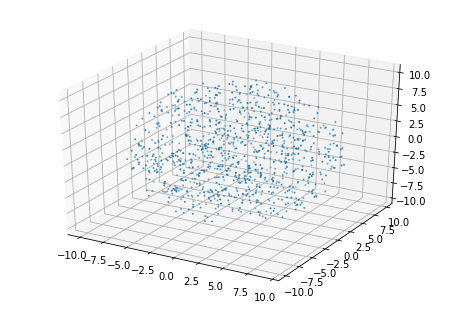

In [79]:
def rand_no_in_sph(n,Rsink):
    theta = np.random.uniform(0,np.pi,n)
    # Instead genreate a uniform projection so we can thhhen project it back!
    costheta = np.random.uniform(-1,1,n)
    sintheta = np.sqrt(1-costheta**2)
    phi = np.random.uniform(0,np.pi*2,n)
    r = np.cbrt(np.random.uniform(0,1,n)*Rsink**3)
    #r = np.random.uniform(0,1,n)
    
    x=sintheta*np.cos(phi)*r
    y=sintheta*np.sin(phi)*r
    z=costheta*r
    return x,y,z
x,y,z = rand_no_in_sph(1000,10)

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x, y, z, s=1)
plt.show()



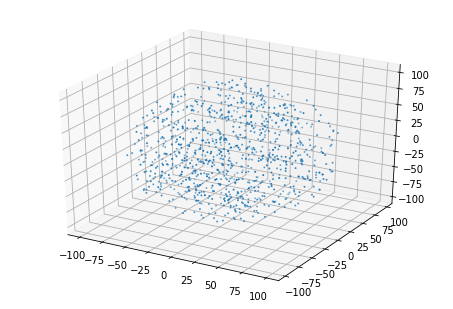

In [2]:
def rand_three_vec_mirror(n=1):
    three_vector = np.zeros((n,3))
    
    phi = np.random.uniform(0,np.pi*2,n)
    costheta = np.random.uniform(-1,1,n)
    #sintheta = np.sqrt(1-costheta**2)
    theta = np.arccos(costheta)
    three_vector[:,0] = np.sin(theta) * np.cos(phi)
    three_vector[:,1] = np.sin(theta) * np.sin(phi)
    three_vector[:,2] = np.cos(theta)
    return three_vector

nnew = 1000
r_sink = 100
sink_pos = (0,0,0)

def star_placement(r_sink):
    star_position = sink_pos + np.cbrt(np.random.rand(nnew,1)*r_sink**3)*rand_three_vec_mirror(nnew)
    return star_position

star_pos = star_placement(r_sink)

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(star_pos[:,0],star_pos[:,1],star_pos[:,2], s=1)
plt.show()

# Choosing Star Velocities

We currently choose stellar velocities by taking the sink's associated gas sound speed as a variance of a gaussian centered around the sink's velocity. Although the sound speed is only sampled from gas $\le 100K$ within 2 accretion radii around the sink, there is a potential issue when said gas is being shohcked by momentum based feedback like stellar winds (which is a certainly possible scenario with the creation of stars $\ge 7$M$_{\odot}$ and placement of them within the sink as discussed before. The sound speed is calculated in `Particles_sinkCreateAccrete.F90`. At the bottom of this file, the gas sound speed and variance is calculated. This is where we will also calculate the total gas mass within the sink at every timestep by looping over each cell, recording the density, volume, and mass of each.

Then, using this mass, we can calculate the virial velocity of said gas and port that over to the velocity given to any star that forms there.

$V_{vir} \equiv \big(\frac{3GM}{5R}\big)^{1/2}$ where M is the total mass of gas within the sink, R is the virial radius (sink radius).

Determining the total gas mass within the sink is relatively straight forward: